In [51]:
#Dependencies
import learn2learn as l2l
import torch
from torch import nn, optim
from torchvision import transforms
from learn2learn.data import TaskDataset
from torchvision.datasets import Omniglot
from learn2learn.data.transforms import NWays, KShots, LoadData, RemapLabels, ConsecutiveLabels
from torchvision.models import resnet18
import random
from collections import defaultdict
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [ ]:
#ResNet 18 backbone for MAML (it was resnet-18 previously but performed bad due to being too much for the dataset
# so replaced it with a 4 layer cnn, but felt lazy to update the names :p)
class ResNet18_enc(nn.Module):
    def __init__(self, output_size=5):  # Number of classes
        super(ResNet18_enc, self).__init__()
        
        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2)
            )
        
        self.encoder = nn.Sequential(
            conv_block(1, 64),    # 28x28 => 14x14
            conv_block(64, 64),   # 14x14 => 7x7
            conv_block(64, 64),   # 7x7 => 3x3
            conv_block(64, 64),   # 3x3 => 1x1
        )

        self.classifier = nn.Linear(64, output_size)

    def forward(self, x):
        x = self.encoder(x)         # Output shape: [batch, 64, 1, 1]
        x = x.view(x.size(0), -1)   # Flatten to [batch, 64]
        x = self.classifier(x)      # Final classification layer
        return x

In [ ]:
# X-way Y-shot task division, gives out 10k tasks
def get_tasksets(ways, shots, test_shots=10):
    conversion = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((28,28)),
        transforms.ToTensor(),
    ])

    Dataset = Omniglot(root='data', background=True, download=True, transform=conversion)

    # Group images by class
    class_to_images = defaultdict(list)
    for img, label in Dataset:
        class_to_images[label].append(img)

    # Only keep classes that have enough samples
    usable_classes = [cls for cls,imgs in class_to_images.items() if len(imgs)>=(shots+test_shots)]

    def sample_task():
        selected_classes = random.sample(usable_classes, ways)  # sample only class names
        support_data, support_labels = [], []
        query_data, query_labels = [], []

        for i, cls in enumerate(selected_classes):
            imgs = class_to_images[cls]

            # Manual shuffle and split instead of random.sample
            random.shuffle(imgs)
            support_imgs = imgs[:shots]
            query_imgs = imgs[shots:shots + test_shots]

            support_data.extend(support_imgs)
            support_labels.extend([i] * shots)

            query_data.extend(query_imgs)
            query_labels.extend([i] * test_shots)

        all_data = torch.stack(support_data + query_data)
        all_labels = torch.tensor(support_labels + query_labels)
        return all_data, all_labels

    class ManualTaskSet:
        def __init__(self, sample_fn):
            self.sample_fn = sample_fn
        def sample(self):
            return self.sample_fn()

    return ManualTaskSet(sample_task)




In [54]:
#Fast adaptation model
def MetaIO_Loops(batch,learner,lossFn,adpSteps,shots,ways,device=torch.device('cuda')):
    data,labels=batch
    data,labels=data.to(device),labels.to(device)

    supportIndex=torch.arange(ways*shots)
    queryIndex=torch.arange(ways*shots,len(data))

    supportData,supportLabels=data[supportIndex],labels[supportIndex]
    queryData,queryLabels=data[queryIndex],labels[queryIndex]

    #inner loop updation
    for i in range(adpSteps):                                                           
        thetaI=learner(supportData)     
        thetaI_loss=lossFn(thetaI,supportLabels)
        learner.adapt(thetaI_loss) 

    #outer loop updation/QSet eval
    Query_theta=learner(queryData)
    QueryvalueLoss=lossFn(Query_theta,queryLabels)
    QueryvalueAccuracy=(Query_theta.argmax(dim=1)==queryLabels).sum().item()/queryLabels.size(0)

    return QueryvalueLoss, QueryvalueAccuracy

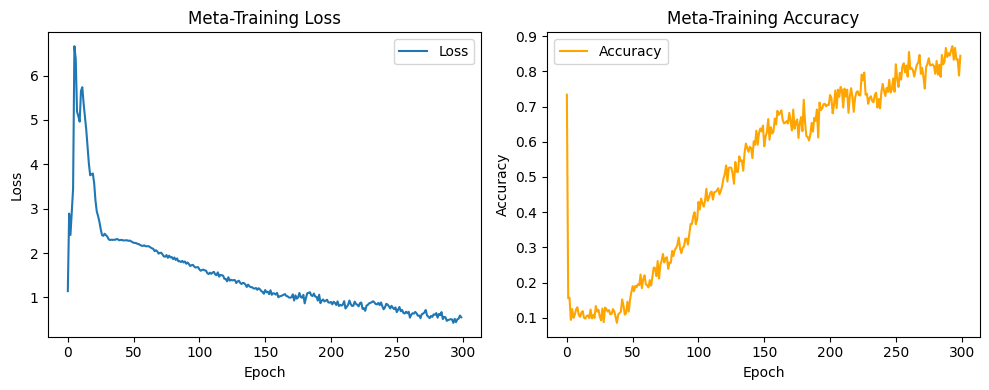

Final Loss: 0.5524
Final Accuracy: 84.43%


In [55]:
def main(ways=10, shots=4, alpha=0.09, beta=0.1, meta_batchSize=14, epoch=300, device=torch.device('cuda')):
    backbone = ResNet18_enc(output_size=ways).to(device)
    metaLearner = l2l.algorithms.MAML(backbone, lr=alpha, first_order=False)
    loss = nn.CrossEntropyLoss()
    optimizer = optim.Adam(metaLearner.parameters(), lr=beta)
    taskSet = get_tasksets(ways, shots)
    
    losses = []
    accuracies = []
    epochs = []

    for it in range(epoch):
        optimizer.zero_grad()
        meta_trainErr, meta_trainAccuracy = 0.0, 0.0
        print(f"Epoch {it+1}/{epoch} started...")
        for task in range(meta_batchSize):
            print(f"  Processing task {task+1}/{meta_batchSize}")
            learner = metaLearner.clone()
            batch = taskSet.sample()
            evalLoss, evalAccuracy = MetaIO_Loops(batch, learner, loss, adpSteps=5, shots=shots, ways=ways, device=device)
            evalLoss.backward()
            meta_trainErr += evalLoss.item()
            meta_trainAccuracy += evalAccuracy

        for p in metaLearner.parameters():
            if p.grad is not None:
                p.grad.data.mul_(1.0 / meta_batchSize)
        optimizer.step()

        avg_loss = meta_trainErr / meta_batchSize
        avg_acc = meta_trainAccuracy / meta_batchSize
        losses.append(avg_loss)
        accuracies.append(avg_acc)
        epochs.append(it)

        # Real-time plot
        clear_output(wait=True)
        plt.figure(figsize=(10,4))
        plt.subplot(1,2,1)
        plt.plot(epochs, losses, label='Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Meta-Training Loss')
        plt.legend()
        plt.subplot(1,2,2)
        plt.plot(epochs, accuracies, label='Accuracy', color='orange')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Meta-Training Accuracy')
        plt.legend()
        plt.tight_layout()
        plt.show()

        if it % 10 == 0:
            print(f"Iter {it}: Loss = {avg_loss:.4f}, Acc = {avg_acc:.4f}")
    print(f"Final Loss: {losses[-1]:.4f}")
    print(f"Final Accuracy: {accuracies[-1]*100:.2f}%")

if __name__ == "__main__":
    main()